# FATS


In [64]:
import pandas as pd
import numpy as np
import functools
import re
import matplotlib.pyplot as plt
import seaborn as sns
from helpers import *
import pygal  

Read all data

In [2]:
data_folder = "./data/"

In [3]:
france = pd.read_csv(data_folder + "france_data.csv.zip", sep=',', dtype=object)

In [4]:
us = pd.read_csv(data_folder + "us_data.csv.zip", sep=',', dtype=object)

Select the "fats" data

In [9]:
butter = r'^(?:.*\s)?butter(?:\s.*)?$'
oil = r'^(?:.*\s)?oil(?:\s.*)?$'
fat_words = [butter, "fats", oil, "beurre", "lätta", "milda", "margarin", "huile", "coconut fat","kerrygold","lurpark","plugra" ]
non_fat_words = ["butter cups", "pop corn", "chicken", "popcorn", "potato", "toffee", "in oil", 
                 "with olive oil", "with oil", "protein bar","olive oil &", "marinat", "in olive oil", 
                 "bean", "snack", "ice cream", "cheese", "fromage", "a l'huile", "à l'huile", "caramel beurre", 
                 "petits beurre", "granola", "frits", "fried", "au beurre", "croissant", "all butter", "yaourt", 
                 "cookie", "chip", "sans huile", "sandwich", "soup", "pur beurre", "thon", "sauce", "chocolat", "chip", 
                 "cookie", "biscuits", "cake", "seafood","chorizo", "joghurt","Foie gras","canard","Mayonnaise"]

In [10]:
france_fats = select_entries(france, fat_words)
print("Fat related items in France before cleaning: " + str(france_fats.shape[0]))

france_fats = clean_categories(france_fats, non_fat_words, ['flour'])
print("Fat related items in France after cleaning: " + str(france_fats.shape[0]))

Fat related items in France before cleaning: 15728
Fat related items in France after cleaning: 7914


In [11]:
us_fats = select_entries(us, fat_words)
print("Fat related items in the US before cleaning: " + str(us_fats.shape[0]))

us_fats = clean_categories(us_fats, non_fat_words, ['flour'])
print("Fat related items in the US after cleaning: " + str(us_fats.shape[0]))

Fat related items in the US before cleaning: 6373
Fat related items in the US after cleaning: 3305


# Distribution in Fats

In [12]:
def create_distribution(df,categories):
    distribution = pd.DataFrame(columns=['tag','category','count'])
    for i in range(categories.shape[0]):
        tag = categories[i,0]
        category = categories[i,1]
        newRow = pd.DataFrame([[tag, category, relevant_rows(df,[tag]).shape[0]]], columns=['tag','category','count'])
        distribution = distribution.append(newRow)
        df = clean_categories(df, [tag])
    return distribution, df.shape[0], df

In [13]:
tags = np.matrix([['cooking spray', "cooking spray"], 
                 ["oliv", "oil"],
                 ["peanut", "peanut butter"],
                 ["oil", "oil"],
                 ["beurre", "butter"],
                 ["margarin", "margarin"],
                 ["butter", "butter"],
                 ["huile", "oil" ],
                 ["lätta", "margarin"],
                 ["becel", "margarin"],
                 ["original", "butter"],
                 ["öl", "oil"],
                ])

In [14]:
france_distri, _, _ = create_distribution(france_fats,tags)
france_distri_grouped = france_distri.groupby(['category']).sum().drop('tag', axis = 1)
france_distri_grouped['procent'] = france_distri_grouped['count'].apply(lambda x: x/france_distri_grouped['count'].sum())
france_distri_grouped['country'] = "France"

In [15]:
us_distri, _, _ = create_distribution(us_fats,tags)
us_distri_grouped = us_distri.groupby(['category']).sum().drop('tag', axis = 1)
us_distri_grouped['procent'] = us_distri_grouped['count'].apply(lambda x: x/us_distri_grouped['count'].sum() )
us_distri_grouped['country'] = "US"

In [76]:
distribution = france_distri_grouped.append(us_distri_grouped).reset_index()
list(us_distri_grouped.T)

['butter', 'cooking spray', 'margarin', 'oil', 'peanut butter']

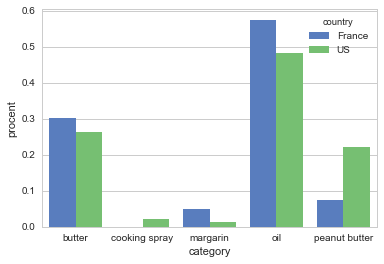

In [21]:
sns.set(style="whitegrid")

g = sns.barplot(x='category', y="procent", hue="country", data=distribution,palette="muted")



In [131]:
bar_chart_distri = pygal.Bar()
bar_chart_distri.title = 'Distribution within fats'
bar_chart_distri.x_labels = list(us_distri_grouped.T)
bar_chart_distri.add('France', france_distri_grouped['procent'] , formatter=lambda y: "{0:.2f}".format(y))
bar_chart_distri.add('US', us_distri_grouped['procent'], formatter=lambda y: "{0:.2f}".format(y))
bar_chart_distri.render_to_file('fats_distribution.svg')  

# Let's look at the nutrition

In [126]:
france_interesting_fats = france_fats[['saturated-fat_100g','monounsaturated-fat_100g',
'polyunsaturated-fat_100g']].astype(float).replace({0.0:np.nan})
us_interesting_fats = us_fats[['saturated-fat_100g','monounsaturated-fat_100g',
'polyunsaturated-fat_100g']].astype(float).replace({0.0:np.nan})


In [127]:
box_chart = pygal.Box()
box_chart.title = 'Saturated fat per 100g'
box_chart.add('France', france_interesting_fats['saturated-fat_100g'].dropna())
box_chart.add('US', us_interesting_fats['saturated-fat_100g'].dropna())
box_chart.render_to_file('fats_saturated-fat.svg')  

In [128]:
box_chart = pygal.Box()
box_chart.title = 'Polyunsaturated fat per 100g'
box_chart.add('France', france_interesting_fats['polyunsaturated-fat_100g'].dropna())
box_chart.add('US', us_interesting_fats['polyunsaturated-fat_100g'].dropna())
box_chart.render_to_file('fats_polyunsaturated-fat.svg') 

In [129]:
box_chart = pygal.Box()
box_chart.title = 'Monounsaturated fat per 100g'
box_chart.add('France', france_interesting_fats['monounsaturated-fat_100g'].dropna())
box_chart.add('US', us_interesting_fats['monounsaturated-fat_100g'].dropna())
box_chart.render_to_file('fats_monounsaturated-fat.svg') 

In [19]:
def re_arange_for_boxplot(df,country):
    new_df = pd.DataFrame(columns=['Y','X','country'])
    column_names = list(df)
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            fat_sort = column_names[j]
            value = df.iloc[i,j]
            newRow = pd.DataFrame([[value,fat_sort,country]],columns=['Y','X','country'])
            new_df = new_df.append(newRow)
        
    return new_df

In [20]:
data_boxplot = re_arange_for_boxplot(france_interesting_fats,"France").append(re_arange_for_boxplot(us_interesting_fats,"US"))

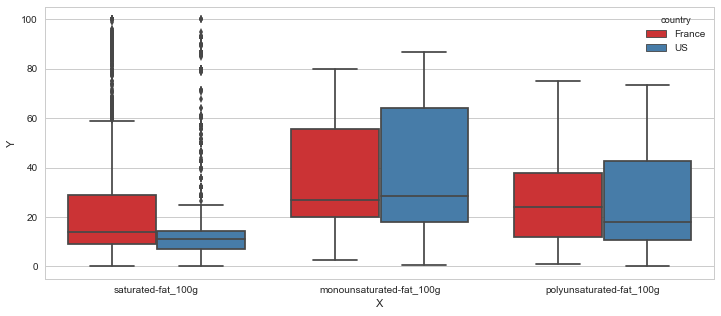

In [21]:
plt.figure(figsize=(12,5))
sns.set(style="whitegrid")
sns.boxplot(x="X",y ="Y", hue="country", data=data_boxplot, palette="Set1")

In [22]:
france_fats_salt = france_fats[['sodium_100g']].astype(float).replace({0.0:np.nan})
us_fats_salt = us_fats[['sodium_100g']].astype(float).replace({0.0:np.nan})
data_boxplot_salt = re_arange_for_boxplot(france_fats_salt,"France").append(re_arange_for_boxplot(us_fats_salt,"US"))


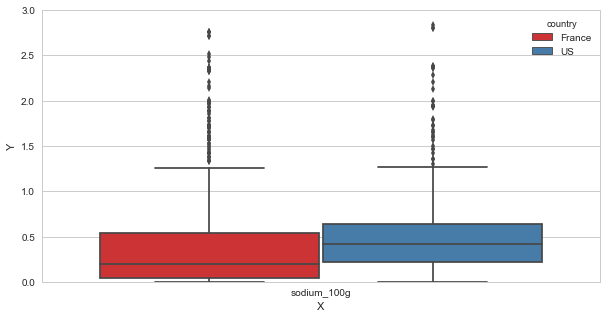

In [23]:
plt.figure(figsize=(10,5))
sns.set(style="whitegrid")
plt.ylim(0, 3)
sns.boxplot(x="X",y ="Y", hue="country", data=data_boxplot_salt, palette="Set1")

# Finally let's look at the portion sizes

In [63]:
france_fats_portion_size = france_fats[['serving_size']].copy()
france_fats_portion_size.dropna(inplace = True)
france_fats_portion_size.head()


,serving_size
422,32 g (2 Tbsp)
423,32 g (2 Tbsp)
934,32 g (2 Tbsp)
938,32 g (2 Tbsp)
1172,14 g (1 Tbsp)


remove letters in the result


In [64]:
france_fats_portion_size = france_fats_portion_size['serving_size'].str.split('(\d+)', expand = True)
france_fats_portion_size[1].astype(float).describe()

count    621.000000
mean      33.669887
std       63.114940
min        0.000000
25%       10.000000
50%       10.000000
75%       29.000000
max      681.000000
Name: 1, dtype: float64

In [65]:
us_fats_portion_size = us_fats[['serving_size']].copy()
us_fats_portion_size.dropna(inplace = True)
us_fats_portion_size = us_fats_portion_size['serving_size'].str.split('(\d+)', expand = True)
us_fats_portion_size[1].astype(float).describe()

count    3242.000000
mean       24.357187
std        25.437998
min         0.000000
25%        14.000000
50%        15.000000
75%        32.000000
max       473.000000
Name: 1, dtype: float64